# Prediction of Gold stock prices using ARIMA

This project is about creating a timeseries prediction model using ARIMA to predict the future daily stock prices of gold. This project involves developing six functions to automate manual tasks and simplify the process of selecting the best ARIMA model for predicting future gold prices.

The developed functions are based on:
- Augmented Dickey-Fuller (ADF) test: The purpose of the ADF test is to determine whether the time series is stationary or non-stationary. Stationarity is a critical assumption for the ARIMA model, which requires a constant mean and variance over time 
- Transform and test: Eight different transformations were created with the purpose of making the data stationary, each transformation is tested with the ADF test.
- ARIMA model evaluation: The ARIMA model is evaluated by fitting it to the stationary data and calculating key metrics such as the Akaike Information Criterion (AIC), Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Square Error (MSE). These metrics help determine the performance of the model. 
- Grid Search: Testing different p,d,q combinations and selecting the best based on the lowest AIC
- Inversing transformations: Inversing the transformed data back to normal values in order to calculate the MAE, MSE, RMSE of the predicted Vs test data.   

**Goal** of this project is to create an automated process that will help the user to select the best ARIMA model for predicting future gold prices.



In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import itertools
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime

---
## Retrieving and plotting historical gold market data 

The code below uses the yfinance library to retrieve the historical market data for the Gold stock, with the ticker symbol "GC=F". The retrieved data is then converted into a Pandas DataFrame object, and the first five rows of the DataFrame are printed for verification.

In [2]:
# Define the ticker symbol for the Gold stock
ticker_symbol = "GC=F"

# Create an instance of the Ticker class from the yfinance library
ticker = yf.Ticker(ticker_symbol)

# Get historical market data
hist = ticker.history(period="max")

# Convert the hist object to a DataFrame
hist_df = pd.DataFrame(hist)

# Result check
hist_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-30 00:00:00-04:00,273.899994,273.899994,273.899994,273.899994,0,0.0,0.0
2000-08-31 00:00:00-04:00,274.799988,278.299988,274.799988,278.299988,0,0.0,0.0
2000-09-01 00:00:00-04:00,277.000000,277.000000,277.000000,277.000000,0,0.0,0.0
2000-09-05 00:00:00-04:00,275.799988,275.799988,275.799988,275.799988,2,0.0,0.0
2000-09-06 00:00:00-04:00,274.200012,274.200012,274.200012,274.200012,0,0.0,0.0


Now that we have the data lets put them in a plot and observe the gold price through the years.

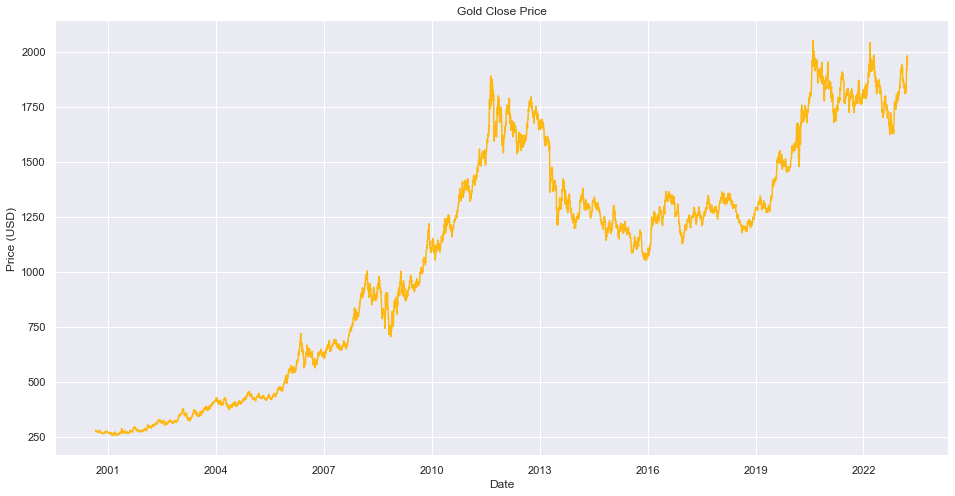

In [3]:
# Set plot style: grey grid in the background:
sns.set(style="darkgrid")
# Set the figure size
plt.figure(figsize=(16, 8))


# Plotting the historical daily gold close price
sns.lineplot(data = hist_df, x='Date', y='Close', color='#FDB813') 
# Setting a plot title
plt.title('Gold Close Price')
# Setting a label for y axes
plt.ylabel('Price (USD)')

# Get the current axis
ax = plt.gca() 
# Set the x-axis major ticks to every 3 years
ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
# Format the x-axis major ticks as years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


---
## Functions dvelopment

**ADF Test**

The `ADF_Test` function performs the ADF test on a given time series. The ADF test is used to determine if a time series is stationary or not, where a stationary time series has constant mean and variance over time. The function prints out the ADF statistic, p-value, and critical values from the test, and then checks if the p-value is less than a pre-defined significance level of 0.05. If the p-value is less than the significance level, the function prints out a message indicating that the null hypothesis is rejected and the time series is stationary; otherwise, it prints out a message indicating that the null hypothesis is not rejected and the time series is not stationary. At the end the function returns the ADF test result.

In [4]:
# Define a function to calculate the ADF test for a time series
def ADF_Test(time_series):
    # Perform the ADF test on the time series
    result = adfuller(time_series)
    
    # Store the ADF statistic and p-value from the test
    ADF_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print the ADF statistic and p-value
    print("ADF Statistic: %f" % ADF_statistic)
    print("p-value: %f" % p_value)
    print("Critical Values:")
    for key, value in critical_values.items():
        print("\t%s: %.3f" % (key, value))
    
    # Check if the p-value is less than the significance level
    significance_level = 0.05
    if p_value < significance_level:
        print("Reject the null hypothesis - Time series is stationary")
    else:
        print("Fail to reject the null hypothesis - Time series is not stationary")
    return result 

**Transformation and test**

The `transform_and_test` function performs various transformations on a given dataframe (`df`) containing time series data, and then applies the ADF test to determine if the transformed series is stationary or not. The function outputs a pandas dataframe that summarizes the results of the ADF test for each transformation, including the ADF statistic, p-value, and critical values, as well as a list of the transformed time series data. The transformations performed include log and differenced log transformations, differenced once and twice transformations, and moving average transformations with and without differencing.

In [5]:
def transform_and_test(df):
    results = []
    list_df = []
    
    # 1. Log and Differenced Log Transformations
    df_log = np.log(df['Close'])
    df_log_diff = df_log.diff().dropna()
    results.append(('Log_Transformation', ADF_Test(df_log)))
    list_df.append({"Log_Transformation": df_log.dropna()})
    results.append(('Differenced_Log_Transformation', ADF_Test(df_log_diff)))
    list_df.append({"Differenced_Log_Transformation": df_log_diff.dropna()})
    
    # 2. Differenced Once & Twice Transformations
    df_diff1 = df['Close'].diff().dropna()
    df_diff2 = df_diff1.diff().dropna()
    results.append(('Differenced_Once_Transformation', ADF_Test(df_diff1)))
    list_df.append({"Differenced_Once_Transformation": df_diff1.dropna()})      
    results.append(('Differenced_Twice_Transformation', ADF_Test(df_diff2)))
    list_df.append({"Differenced_Twice_Transformation": df_diff2.dropna()})  
    
    # 3. Moving Average Transformations
    df['Moving_Average'] = df['Close'].rolling(window=14, closed='left').mean()
    df['Moving_Average_with_difference'] = df['Close'] - df['Moving_Average']
    df_diff1_MA = df['Moving_Average'].diff().dropna()
    df_diff1_MAD = df['Moving_Average_with_difference'].diff().dropna()
    df_MA = df['Moving_Average'].rename('Close')
    df_MAD = df['Moving_Average_with_difference'].rename('Close')
    df_diff1_MA = df_diff1_MA.rename('Close')
    df_diff1_MAD = df_diff1_MAD.rename('Close')
    results.append(('Moving_Average', ADF_Test(df_MA.dropna())))
    list_df.append({"Moving_Average": df_MA.dropna()})
    results.append(('Moving_Average_with_difference', ADF_Test(df_MAD.dropna())))
    list_df.append({"Moving_Average_with_difference": df_MAD.dropna()})
    results.append(('Differenced_Moving_Average', ADF_Test(df_diff1_MA)))
    list_df.append({"Differenced_Moving_Average": df_diff1_MA.dropna()}) 
    results.append(('Differenced_Moving_Average_Difference', ADF_Test(df_diff1_MAD)))
    list_df.append({"Differenced_Moving_Average_Difference": df_diff1_MAD.dropna()})   
    
    
    # Convert the list of results into a pandas dataframe
    results_df = pd.DataFrame(results, columns=['Method', 'ADF Test Result'])
      
    
    # Adding the critical values, p-value and ADF statistic to the results_df
    for i, row in results_df.iterrows():
        test_result = row['ADF Test Result']
        results_df.at[i, 'p-value'] = test_result[1]       
        results_df.at[i, 'ADF Statistic'] = test_result[0]
        results_df.at[i, '1% Critical Value'] = test_result[4]['1%']
        results_df.at[i, '5% Critical Value'] = test_result[4]['5%']
        results_df.at[i, '10% Critical Value'] = test_result[4]['10%']
        results_df.at[i, 'Stationarity'] = 'Reject' if test_result[0] < test_result[4]['1%'] else 'Fail to Reject'
        
        
    return results_df, list_df

**Evaluation of Arima Model**

The `evaluate_arima_model` function takes a time series (`X`) and an ARIMA order (`arima_order`) as input. It splits the data into training and testing sets, fits an ARIMA model using the training set, and makes predictions for the test set. The function then evaluates the predictions by calculating the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Squared Error (MSE), and Akaike Information Criterion (AIC). Finally, the function returns these evaluation metrics.

In [6]:
def evaluate_arima_model(X, arima_order):
    # Splitting the data into train and test set (70% and 30% respectively)
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    
    # Creating a list of the training set to be used as history for ARIMA model
    history = [x for x in train]
    predictions = list()

    # For each test data, fit the ARIMA model and make predictions
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # Evaluate the predictions by calculating RMSE, MAE, MSE, and AIC 
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    aic = model_fit.aic

    # Return the evaluation results
    return rmse, mae, mse, aic

**Grid search**

The function `grid_search_arima` performs a grid search over different combinations of p, d, and q values for the ARIMA model. It takes as input a list of dictionaries, each containing a time series dataset, and lists of p, d, and q values to be searched over. For each dataset, the function loops over all possible combinations of p, d, and q values and evaluates the ARIMA model with each combination using the `evaluate_arima_model` function. It then selects the best performing configuration based on the AIC value and saves the corresponding RMSE, MAE, MSE, and AIC values. The function returns the results for each dataset as a Pandas DataFrame.

In [7]:
def grid_search_arima(data_dicts, p_values, d_values, q_values):
    # Initialize an empty list to store the results of each iteration
    results = []
    
    # Loop over each data dictionary in the list
    for data_dict in data_dicts:
        # Initialize variables to store the best configuration and its score
        best_score, best_cfg = float("inf"), None
        # Get the data from the current dictionary
        data = list(data_dict.values())[0]
        # Get the name of the data from the current dictionary
        name =  list(data_dict.keys())[0]
        # Initialize the AIC value with infinity
        aic = float("inf")
        # Initialize the RMSE and MAE values with infinity
        best_rmse, best_mae = float("inf"), float("inf")
        
        # Loop over each possible p value
        for p in p_values:
            # Loop over each possible d value
            for d in d_values:
                # Loop over each possible q value
                for q in q_values:
                    # Combine p, d, and q into a single order tuple
                    order = (p,d,q)
                    try:
                        # Evaluate the ARIMA model with the current order
                        rmse, mae, mse, aic_ = evaluate_arima_model(data, order)
                        # If the current configuration has a lower AIC, update the best configuration and score
                        if aic_ < aic:
                            # Update the best score, configuration, AIC, RMSE, and MAE
                            best_score, best_cfg = mse, order
                            aic = aic_
                            best_rmse, best_mae = rmse, mae
                            print(f"Name: {name}, ARIMA: {best_cfg}, AIC: {aic}, RMSE: {best_rmse}, MAE: {best_mae}, MSE: {best_score}")

                    except:
                        # If an error occurs, continue to the next iteration
                        continue
        # Add the results for the current iteration to the list of results
        results.append({'Name': name, 'ARIMA': best_cfg, 'MSE': best_score, 'AIC': aic, 'RMSE': best_rmse, 'MAE': best_mae})
    # Return the results as a Pandas DataFrame
    return pd.DataFrame(results)

***Selecting data based on ranges***

This function takes a pandas DataFrame (`df`) and two parameters representing the starting index (`start2`) and ending index (`finish2`) of the data that need to be retrieved. It returns the portion of the DataFrame that lies between the specified start and finish indices.

In [8]:
# Defining a function that gets the data that are located between start and finish
def get_range(df,start, finish):
    return df[start:finish]

**Inverse Transformation**

This function takes in three arguments: `future_df`, `hist_df1`, and `selected_method`. It performs inverse transformations on the predicted values based on the selected method. The methods of Log Transformation, Differenced Log Transformation, Differenced Once Transformation, Differenced Twice Transformation, Moving Average, Moving Average with Difference, and Differenced Moving Average are derived from the `transform_and_test` function above. Each method has its own way of transforming and inverting the data, which is explained in the function. The inverse transformed values are stored in inverse_predicted, which is returned by the function.

In [9]:
def inverse_transform(future_df, hist_df1, selected_method):
    
    # Inverse of Log transformation
    if selected_method == 'Log_Transformation': 
        # Undo the logarithmic transformation
        inverse_predicted = np.exp(future_df)
    
    # Inverse of Differenced Log transformation
    elif selected_method == 'Differenced_Log_Transformation': 
        # First, undo the differencing
        predicted_diff = future_df.cumsum()
        
        # Add back the previous value of the log-transformed series
        df_logged = np.log(hist_df1)
        first_value = df_logged.iloc[-1, 0]
        predicted_log = first_value + predicted_diff
    
        # Undo the logarithmic transformation
        inverse_predicted = np.exp(predicted_log)
    
    # Inverse of 1st order difference transformation
    elif selected_method == 'Differenced_Once_Transformation': 
        inverse_predicted = hist_df1.iloc[-1,0] + future_df.cumsum()
    
    # Inverse of 2nd order difference transformation
    elif selected_method == 'Differenced_Twice_Transformation': 
         
        # Transforming the close values with 2nd order difference
        hist_df1['df_diff1'] = hist_df1['Close'].diff()
        hist_df1['df_diff2'] = hist_df1['df_diff1'].diff()
      
        # Integrate once to obtain the first-order differenced predicted values
        predicted_diff1_reverse = hist_df1['df_diff1'].iloc[len(hist_df1)-1] + future_df.cumsum()

        # Find the last value of the original series
        last_value = hist_df1['Close'].iloc[len(hist_df1)-1]
         
        # Integrate the first-order differenced predicted values again to obtain the predicted original series
        inverse_predicted = last_value + predicted_diff1_reverse.cumsum()

    # Inverse of Moving Average transformation    
    elif selected_method == 'Moving_Average': 
    
        # Transforming the historical data with the Moving Average method
        hist_df1['Moving_Average'] = hist_df1['Close'].rolling(window=14, closed='left').mean()
    
        # Selecting the transformed data
        hist_df12 =  hist_df1[['Moving_Average']]

        # Merge the DataFrames based on their index
        merged_df = pd.merge(hist_df12, hist_df1, left_index=True, right_index=True)
        
        # Renaming the column 
        NewDF = future_df.rename(columns = {'Predictions':'Moving_Average'})

        # Concatenate the dataframes
        merged_df1 = pd.concat([merged_df, NewDF])

        # Inverse the moving average
        for na in merged_df1['Close']:
            merged_df1['Close'] =  merged_df1['Close'].fillna((merged_df1['Moving_Average'].shift(-1) * 14) - merged_df1['Close'].rolling(window=13, closed='left').sum())

        # Creating a new dataframe with the predictions
        Actual_Prediction = merged_df1[['Close']].copy()

        # Using the get_range function to get the inversed data 
        start2 = len(hist_df1) - 14
        finish2= start2 + len(future_df)
        inverse_predicted = get_range(Actual_Prediction,start2,finish2 )

        # Drop nas 
        inverse_predicted = inverse_predicted.dropna(subset=['Close'])

        # Renaming the column into predictions
        inverse_predicted = inverse_predicted.rename(columns = {'Close':'Predictions'})
    
    # Inverse of Moving Average with difference transformation
    elif selected_method == 'Moving_Average_with_difference': 

        # Transforming the historical data with the Moving Average first and then taking its difference from the actual value
        hist_df1['Moving_Average'] = hist_df1['Close'].rolling(window=14, closed='left').mean()
        hist_df1['Moving_Average_with_difference'] = hist_df1['Close'] - hist_df1['Moving_Average']
        
        # Selecting the transformed data
        hist_df12 =  hist_df1['Moving_Average_with_difference'].dropna()

        # Renaming the column 
        NewDF = future_df.rename(columns = {'Predictions':'Moving_Average_with_difference'})

        # Converting the series into a dataframe
        hist_df11 = hist_df12.to_frame()

        # concatenate the dataframes
        dfCombined = pd.concat([hist_df11, NewDF])

        # Adding the actual results   
        dfCombined = dfCombined.join(Traindf['Close']) 
 
        # Calculating the inverse of  Moving Average with difference
        for i in dfCombined.index:
            dfCombined['Close'] = dfCombined['Close'].fillna(dfCombined['Close'].rolling(window = 14, closed='left' ).mean()+ dfCombined['Moving_Average_with_difference'])

        # Calculating the actual prediction
        dfCombined['Prediction_Reverted'] = dfCombined['Close'] 

        # Creating a new dataframe with the predictions
        Actual_Prediction = dfCombined[['Prediction_Reverted']].copy()

        # Using the get_range function to get the inversed data 
        start2 = len(hist_df1)-14
        finish2= start2 + len(future_df)
        inverse_predicted = get_range(Actual_Prediction,start2,finish2 )
        
        # Renaming the column
        inverse_predicted = inverse_predicted.rename(columns = {'Prediction_Reverted':'Predictions'})

    # Inverse of Differenced Moving Average transformation
    elif selected_method == 'Differenced_Moving_Average': 
    
        # Transforming the historical data with the Differenced Moving Average method
        hist_df1['Moving_Average'] = hist_df1['Close'].rolling(window=14, closed='left').mean()
        hist_df1['Differenced_Moving_Average'] = hist_df1['Moving_Average'].diff().dropna()

        #Renaming the dataframe
        merged_df = hist_df1
        
        # Renaming the column 
        NewDF = future_df.rename(columns = {'Predictions':'Differenced_Moving_Average'})

        # Concatenate the dataframes
        merged_df1 = pd.concat([merged_df, NewDF])

        # Inverse of difference
        merged_df1['undiff'] = merged_df1['Differenced_Moving_Average'].cumsum()

        # Replace the most recent date value with NaN
        Last_Day = hist_df1.index[-1]
        merged_df1.at[pd.to_datetime(Last_Day), 'Close'] = np.nan

        # Inverse the moving average
        for na in merged_df1['Close']:
            merged_df1['Close'] =  merged_df1['Close'].fillna((merged_df1['undiff'].shift(-1) * 14) - merged_df1['Close'].rolling(window=13, closed='left').sum())

        # Creating a new dataframe with the predictions
        Actual_Prediction = merged_df1[['Close']].copy()

        # Using the get_range function to get the inversed data 
        start2 = len(hist_df1) 
        finish2= start2 + len(future_df)
        inverse_predicted = get_range(Actual_Prediction,start2,finish2 )

        # Drop nas 
        inverse_predicted = inverse_predicted.dropna(subset=['Close'])

        # Renaming the column into predictions
        inverse_predicted = inverse_predicted.rename(columns = {'Close':'Predictions'})
        
        # Replace negative values with nothing
        inverse_predicted[inverse_predicted < 0] = pd.np.nan
        
        # Interpolate the missing values using the linear method
        inverse_predicted = inverse_predicted.interpolate(method='linear')
        
        # Replace remaining NaN values with zero
        inverse_predicted = inverse_predicted.fillna(0)

    # Inverse the Differenced Moving Average with difference transformation
    elif selected_method == 'Differenced_Moving_Average_Difference':
        
        # Transforming the historical data with the Differenced Moving Average with Difference method
        hist_df1['Moving_Average'] = hist_df1['Close'].rolling(window=14, closed='left').mean()
        hist_df1['Moving_Average_with_difference'] = hist_df1['Close'] - hist_df1['Moving_Average']
        hist_df1['Differenced_Moving_Average_with_difference']  = hist_df1['Moving_Average_with_difference'].diff().dropna()
    
        # Renaming the columns 
        NewDF = future_df.rename(columns = {'Predictions':'Differenced_Moving_Average_with_difference'})
    
        # Merging the prefdicted and differenced values
        merged_df = pd.concat([hist_df1,NewDF], axis=0, join='outer')
        
        # Calculating the inverse of  Moving Average with difference
        merged_df['inv_diff'] = merged_df['Differenced_Moving_Average_with_difference'] + merged_df['Moving_Average_with_difference'].shift(1)
    
        # Inversing back to actual results
        for nan in merged_df['Close']:  
            
            merged_df['Close'] = merged_df['Close'].fillna(merged_df['inv_diff'] + merged_df['Moving_Average']) 
            
            merged_df['Moving_Average'] = merged_df['Moving_Average'].fillna(merged_df['Close'].rolling(window=14, closed='left').mean())  
            
            merged_df['Moving_Average_with_difference'] = merged_df['Moving_Average_with_difference'].fillna(merged_df['Close'] - merged_df['Moving_Average'])  
            
            # Add first value of differenced moving average with difference back to the series
            merged_df['inv_diff'] = merged_df['inv_diff'].fillna(merged_df['Differenced_Moving_Average_with_difference'] + merged_df['Moving_Average_with_difference'].shift(1))
        
        # Creating a new dataframe with the predictions
        Actual_Prediction = merged_df[['Close']].copy() 
        
        # Using the get_range function to get the inversed data 
        start2 = len(hist_df1) 
        finish2= start2 + len(future_df)
        inverse_predicted = get_range(Actual_Prediction,start2,finish2 )
     
        # Renaming the columns     
        inverse_predicted = inverse_predicted.rename(columns = {'Close':'Predictions'})

    else:
        raise ValueError(f"Invalid selected method: {selected_method}")
        
    return inverse_predicted



---
# Functions Application


To start, we will apply functions to a predefined period in our dataset. Initially, I attempted to fit the ARIMA model on the complete dataset, but the results were not satisfactory. As a solution, I divided the data into several datasets based on periods starting from January 2022 and onward, with each dataset having a month less than the previous one. For instance, one dataset is based on data from January 2022 onwards, while the next dataset is based on data from February 2022 onwards. The ARIMA model is then trained on each dataset, and predictions are made. These predictions are compared to the test values, and the best dataset to train the model is selected. This dataset is then used for future predictions.

In [10]:
# Get the current date
current_date = datetime.datetime.now()

# Subtract one month from the current date
last_month = current_date - datetime.timedelta(days=current_date.day)

# Set the day of the resulting date object to 1
first_day_of_last_month = last_month.replace(day=1)

# Create a range of dates from 2022-01-01 to current month with a one-month frequency
date_range = pd.date_range(start='2022-01-01', end=first_day_of_last_month, freq='MS')

# Create a DataFrame with one column named 'Date' and the range of dates as its values
DateFilters = pd.DataFrame({'Date': date_range})

# Converting into date and time
DateFilters['Date'] = pd.to_datetime(DateFilters['Date'])

# Removing timezone from index dates
hist_df.index = hist_df.index.tz_localize(None)

In [11]:
# Creating lists and dataframes that will store the data created from the loop 
Evaluations =pd.DataFrame()
Transformations =pd.DataFrame()
All_Data = []
Arima_Orders = []
All_Transformations =pd.DataFrame() 


After setting the minimum dates, we filter the data to extract the desired subsets, and then apply the predefined functions to each dataset. We then plot the predicted values versus the test data for each dataset, which provides a visual representation of how well the model performs on the provided training data. Additionally, we compute evaluation metrics such as RMSE, MAE, MSE, and AIC, and store the results in an 'Evaluations' dataframe. This enables us to compare the performance of different datasets and select the one that produces the best results.

ADF Statistic: -1.233784
p-value: 0.658896
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Fail to reject the null hypothesis - Time series is not stationary
ADF Statistic: -17.914770
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Reject the null hypothesis - Time series is stationary
ADF Statistic: -17.960963
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Reject the null hypothesis - Time series is stationary
ADF Statistic: -8.974138
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Reject the null hypothesis - Time series is stationary
ADF Statistic: -1.347767
p-value: 0.607046
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Fail to reject the null hypothesis - Time series is not stationary
ADF Statistic: -4.399595
p-value: 0.000297
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Reject the null hypothesis - Time series is stationary
ADF Statistic: -3.074041
p-value: 0.028535
Critical Values:
	1

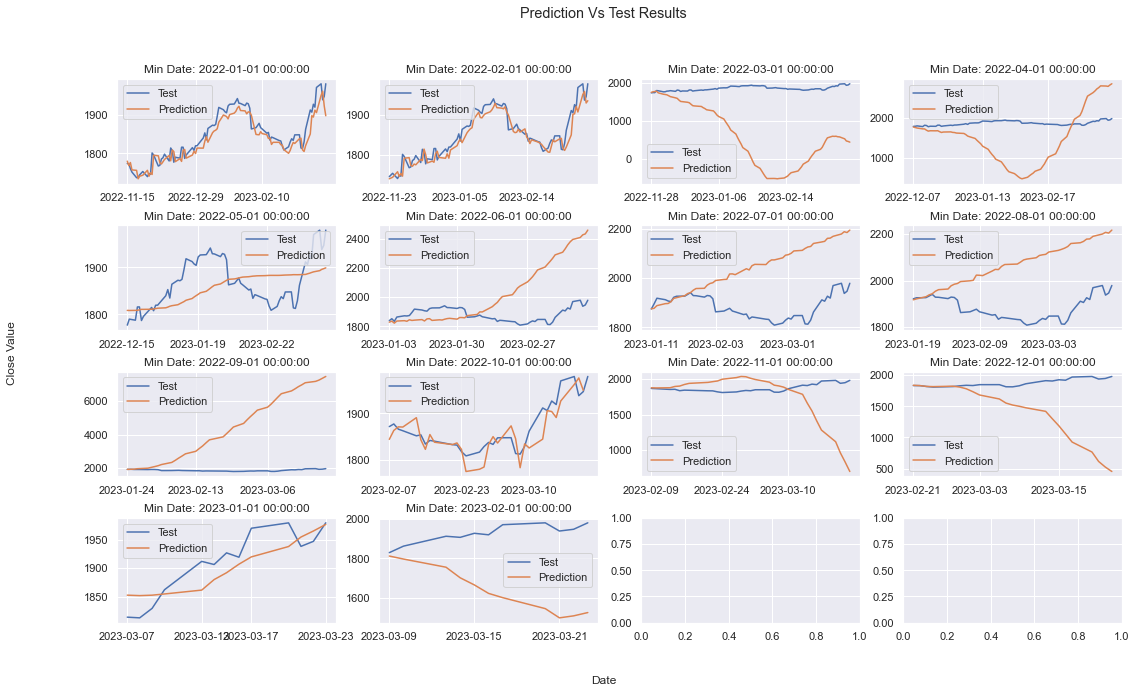

In [12]:
# Plots multiple graphs in one figure
fig, ax = plt.subplots(4, 4,  figsize=(18,10)) 

subplot_count = 0

for d in DateFilters['Date']:
    #  Filter the dataframe to show rows after the selected date d
    FilteredDF = hist_df[hist_df.index >= d] 
    
    # Apply the transform_and_test function to the dataset 
    transformation_results = transform_and_test(FilteredDF)
    
    # Sort the test of each transformation based on Stationarity, ADF Statistic, and P-Value ###***Try sorting true based on p value it looks promissing***###
    Transformations_Results = transformation_results[0].sort_values(by=['Stationarity','ADF Statistic','p-value'], ascending=[False,False,True])
    
    # Adding the minimum date to the transformations Results
    Transformations_Results['Min_Date'] =  d

    # Selects the dataframe with the transformation results  
    Transformations_DFS=transformation_results[1]
    
    # Filtering the best transformation ny selecting the top row of Transformations_Results after sorting
    Transformations_to_keep = Transformations_Results['Method'].values[:1]
    Filtered_Transformations = [d for d in Transformations_DFS if any(k in d for k in Transformations_to_keep)]
    
    # Keeping only the stanionary trasnformations
    Stationary_Transformations=Transformations_Results.loc[Transformations_Results['Stationarity'] == "Reject" ]
    
    # Appending the stationary transformations
    All_Transformations = All_Transformations.append(Stationary_Transformations)
    
    # If there are no stationary transformations the loop continues to the next filtered dataset
    if len(Stationary_Transformations) == 0:
        continue
    
    # Extracting the best transformation from the list of dictonaries into a separate dataframe
    for dictionary in Filtered_Transformations:
        dataframe_name = list(dictionary.keys())[0]
        dataframe = list(dictionary.values())[0]
        globals()[dataframe_name] = dataframe
    
    # Setting the P, D, Q parameters combinations 
    p_values = range(0, 8)
    d_values = range(0, 2)
    q_values = range(0, 8)
    
    # Applying the grid_search_arima function to the filtered transformation and printing the best results
    Grid_Search_results_df = grid_search_arima(Filtered_Transformations, p_values, d_values, q_values)
    print(Grid_Search_results_df)
    
    # Selecting the order with the best results 
    order = tuple(Grid_Search_results_df['ARIMA'].iloc[0])
    
    # Convert the array to a string
    arr_str = np.array2string(Transformations_to_keep)
    
    # Remove the '[' and ']' characters
    arr_str = arr_str.replace('[', '').replace(']', '')
    
    # Remove the single quotes and the remaining whitespace
    arr_str = arr_str.replace("'", "").strip()
    
    # Selecting the Transformed series
    X =  globals()[arr_str]
    
    # Splitting the data into train and test set (70% and 30% respectively)
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
        
    # Creating a list of the training set to be used as history for ARIMA model
    history = [x for x in train]
    predictions = list()
    
    # For each test data, fit the ARIMA model and make predictions
    for t in range(len(test)):
        model = ARIMA(history, order=order )
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # Printing the model summary
    print(model_fit.summary())
    
    # Combine the predictions with the future dates to create a new dataframe
    Predictionsdf = pd.DataFrame({'Date': test.index, 'Predictions': predictions}).set_index('Date')
    
    # Selecting the Test actual values
    Testdf2 = FilteredDF.loc[Predictionsdf.index, "Close"]
    Testdf = Testdf2.to_frame()
    
    # Exluding the index and values of the Predictions
    Traindf2 = FilteredDF.loc[~FilteredDF.index.isin(Predictionsdf.index), 'Close']
    Traindf =Traindf2.to_frame()
    
    # Select the method that was choosen to make the series stationary
    selected_method = Grid_Search_results_df['Name'].iloc[0]
        
    # Applying the inverse transformation function to inverse the predicted results back to actual values
    inverse_predicted = inverse_transform(Predictionsdf, Traindf, selected_method)
    
    # Evaluating the predictions by calculating RMSE, MAE, MSE, and AIC 
    if  selected_method  == 'Differenced_Moving_Average'  :
        rmse = np.sqrt(mean_squared_error(Testdf.drop(Testdf.index[-1]), inverse_predicted))
        mae = mean_absolute_error(Testdf.drop(Testdf.index[-1]), inverse_predicted)
        mse = mean_squared_error(Testdf.drop(Testdf.index[-1]), inverse_predicted)
        aic = model_fit.aic
    else:
        rmse = np.sqrt(mean_squared_error(Testdf, inverse_predicted))
        mae = mean_absolute_error(Testdf, inverse_predicted)
        mse = mean_squared_error(Testdf, inverse_predicted)
        aic = model_fit.aic     
    
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Akaike Information Criterion (AIC): {aic}")
    
    # Create an empty dataframe with three columns
    Evaluation = pd.DataFrame(columns=['aic', 'mse', 'mae', 'rmse', 'Min_Date'])
    
    # Append the numbers stored in variables to the dataframe
    Evaluation = Evaluation.append({'Min_Date': d, 'aic': aic, 'mae': mae, 'mse': mse, 'rmse': rmse}, ignore_index=True)
    
    # Append the evaluation and transformation results into dataframes
    Evaluations = Evaluations.append(Evaluation, ignore_index=True)
    Transformations = Transformations.append(Transformations_Results.head(1), ignore_index=True)

    # Append the order into a list
    Order_df = pd.DataFrame([order], columns=['AR', 'I', 'MA'])
    Order_df['Date'] = d
    Arima_Orders.append(Order_df)

    """
    Plotting the Prediction Vs Test 
    """
    
    # Combine the two lists into a single data frame
    Test_Pred = pd.concat([inverse_predicted, Testdf], axis=1)

    # Plot the Test_Pred dataframe on a subplot
    sns.lineplot(data=Test_Pred, x='Date', y='Close', ax=ax[subplot_count // 4, subplot_count % 4], label = 'Test')
    sns.lineplot(data=Test_Pred, x='Date', y='Predictions', ax=ax[subplot_count // 4, subplot_count % 4], label = 'Prediction')
    
    # Removing the labels from x and y axes
    ax[subplot_count // 4, subplot_count % 4].set_xlabel('')
    ax[subplot_count // 4, subplot_count % 4].set_ylabel('')
    
    # Spacing out the labels of x axes 
    n = round(len(Test_Pred.index)/3)
    ax[subplot_count // 4, subplot_count % 4].set_xticks(Test_Pred.index[::n])
    
    # Adding the min date as a title
    ax[subplot_count // 4, subplot_count % 4].set_title(f"Min Date: {d}")
    
    # Increment the subplot counter
    subplot_count += 1
    
    # Add a legend to the first subplot
    if subplot_count == 0:
        ax[subplot_count // 4, subplot_count % 4].legend(loc='upper right')
     
    # Select the DataFrame from the list using the string name
    selected_df_dict = next((item for item in Filtered_Transformations if selected_method in item), None)
    Transformed = selected_df_dict[selected_method] if selected_df_dict is not None else None
    Transformed = Transformed.to_frame()
    Transformed = Transformed.rename(columns = {'Close':'Transformed'})
    inverse_predicted = inverse_predicted.rename(columns = {'Predictions':'Inversed'})
    
    # Left join All and other dataframes based on their index
    All = FilteredDF['Close'].to_frame()
    All = All.join(inverse_predicted, how='left')
    All = All.join(Predictionsdf, how='left')
    All = All.join(Transformed, how='left')
    All_Dictionary = [{'Selected_Method': selected_method},{'Data': All}, {'Min_Date': d}]
    All_Data.append(All_Dictionary)

# Add a title and labels to the plot
fig.suptitle("Prediction Vs Test Results")
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Close Value', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.4)

# Remove scientific format from the axes
for a in ax.flat:
    a.ticklabel_format(style='plain', axis='y')

# Show the plot
plt.show()


In [13]:
# Print the evaluation results of each dataset
print(Evaluations.sort_values(by=['mae'],ascending=[True]))

            aic           mse          mae         rmse   Min_Date
1   2350.372242  4.237264e+02    16.014387    20.584614 2022-02-01
0     16.000000  5.494187e+02    18.368261    23.439681 2022-01-01
9    373.352436  6.788760e+02    20.413398    26.055249 2022-10-01
12   358.687759  1.003163e+03    27.765168    31.672755 2023-01-01
4   1896.740877  2.582799e+03    43.998988    50.821243 2022-05-01
6   1433.285417  3.571158e+04   156.466940   188.975073 2022-07-01
5   1608.306906  6.187829e+04   186.106059   248.753471 2022-06-01
7   1269.468567  4.563818e+04   186.984952   213.630940 2022-08-01
10   840.361552  1.942280e+05   278.645097   440.713093 2022-11-01
13   299.422405  1.026224e+05   283.346219   320.347276 2023-02-01
11   653.998523  4.804368e+05   481.674564   693.135464 2022-12-01
3   2070.643308  5.745626e+05   620.326297   757.999044 2022-04-01
2   2293.965787  2.190023e+06  1247.422364  1479.872722 2022-03-01
8   1192.324835  9.796569e+06  2486.862958  3129.947052 2022-0

The plots provided allow us to visualize and comprehend the relationship between the predicted and test data for each period, enabling us to select a dataset where the predictions follow the test data closely. We can also assess the quality of our choices by examining the evaluation metrics obtained. The most recent dataset, with a minimum date of 01-10-2022, yielded satisfactory results, with a MAE of 20 and an AIC of 373. Therefore, we will choose this time period to train an ARIMA model on the transformed dataframe and make future predictions. Additionally, other datasets also produced satisfactory results. For example, the dataset of 01-02-2022 had the lowest MAE, while the dataset of 01-01-2022 had the lowest AIC.

In [37]:
# Selecting the order based on the date of best model   
target_date =pd.to_datetime('2022-10-01')

# loop through the list of dataframes and select the dataframe with the matching date
for df in Arima_Orders:
    if df['Date'][0] == target_date:
        selected_order = df
        break   
    
# Create a tuple from the 'ar', 'i', and 'ma' columns
order_future_pred = tuple(selected_order[['AR', 'I', 'MA']].values[0])

# Selecting the transformed dataset 
for data_dict in All_Data:
    if data_dict[2]['Min_Date'] == target_date:
        Selected_Transformed_df = data_dict[1]['Data']
        Selected_Method_Future =data_dict[0]['Selected_Method']
        break

X_History = Selected_Transformed_df['Transformed']
Histdf = Selected_Transformed_df[['Close']]



Below the model is trained on the selected data, and used to make a 15-day ahead prediction.

In [46]:

# Fit an ARIMA model with the best parameters (5,1,5)
model = ARIMA(X_History, order=order)
model_fit = model.fit()

#Setting the future steps to predict
steps = 15

# Generate future predictions for the next 60 days
predictions = model_fit.forecast(steps=steps)

# Create a date range for the future predictions
future_dates = pd.date_range(start=X_History.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D')

# Combine the predictions with the future dates to create a new dataframe
future_df = pd.DataFrame({'Date': future_dates, 'Predictions': predictions})

# Set the 'date' column as the index
future_df = future_df.set_index('Date')

# Applying the inverse transformation function 
inverse_predicted_future = inverse_transform(future_df, Histdf, Selected_Method_Future)


Now we are able to plot the future predictions and observe the gold price future behavior.

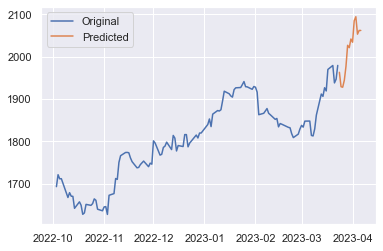

In [47]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the original time series and the predicted values
plt.plot(Histdf['Close'], label='Original')
plt.plot( inverse_predicted_future, label='Predicted')
plt.legend()
plt.show()